# Libs

In [1]:
import datetime
import numpy as np

from itertools import islice, cycle
from more_itertools import pairwise

import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(17, 9)})

from IPython.core.display import display, HTML, clear_output
display(HTML('<style>.container { width:80% !important; }</style>'))
display(HTML('<style>.prompt { min-width:10ex !important; }</style>'))
display(HTML('<style>div#notebook { font-size:12px !important; }</style>'))

# Data

In [2]:
users_df = pd.read_csv('users.csv')
items_df = pd.read_csv('items.csv')
interactions_df = pd.read_csv('interactions_df.csv', parse_dates=['last_watch_dt'])
submission = pd.read_csv('sample_submission.csv')

# EDA

## Users

In [3]:
users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [4]:
users_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   840197 non-null  int64 
 1   age       826102 non-null  object
 2   income    825421 non-null  object
 3   sex       826366 non-null  object
 4   kids_flg  840197 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 32.1+ MB


In [5]:
users_df.nunique()

user_id     840197
age              6
income           6
sex              2
kids_flg         2
dtype: int64

### Preprocess

#### Age

<AxesSubplot:>

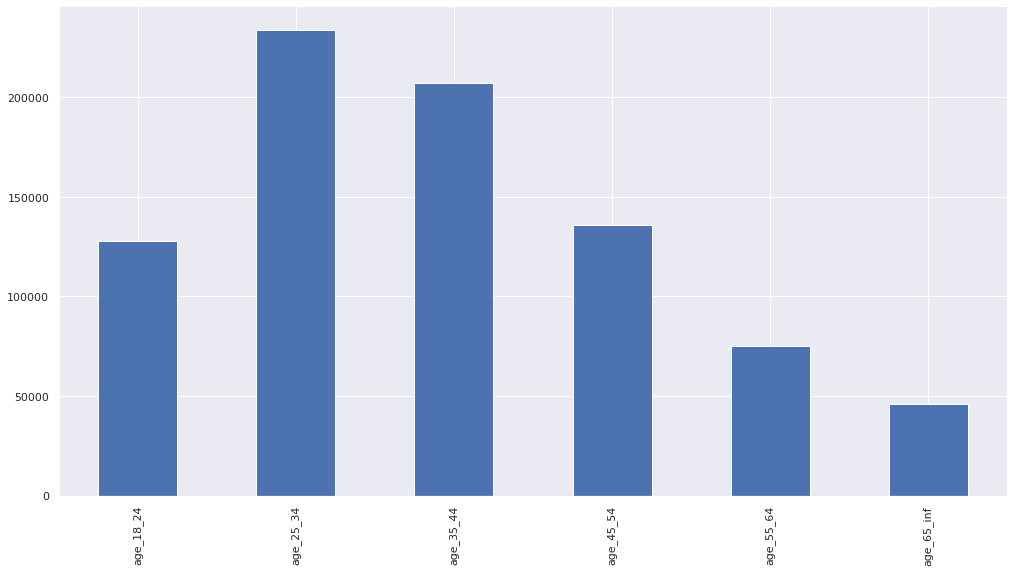

In [6]:
users_df.age.value_counts().sort_index().plot(kind='bar')

In [7]:
users_df['age'] = users_df['age'].fillna('age_unknown')

In [8]:
users_df['age'].value_counts()

age_25_34      233926
age_35_44      207043
age_45_54      135925
age_18_24      127672
age_55_64       75265
age_65_inf      46271
age_unknown     14095
Name: age, dtype: int64

In [9]:
users_df['age'] = users_df['age'].astype('category')

#### Income

In [10]:
users_df.income.value_counts()

income_20_40      471519
income_40_60      248330
income_60_90       68674
income_0_20        21836
income_90_150      13985
income_150_inf      1077
Name: income, dtype: int64

<AxesSubplot:>

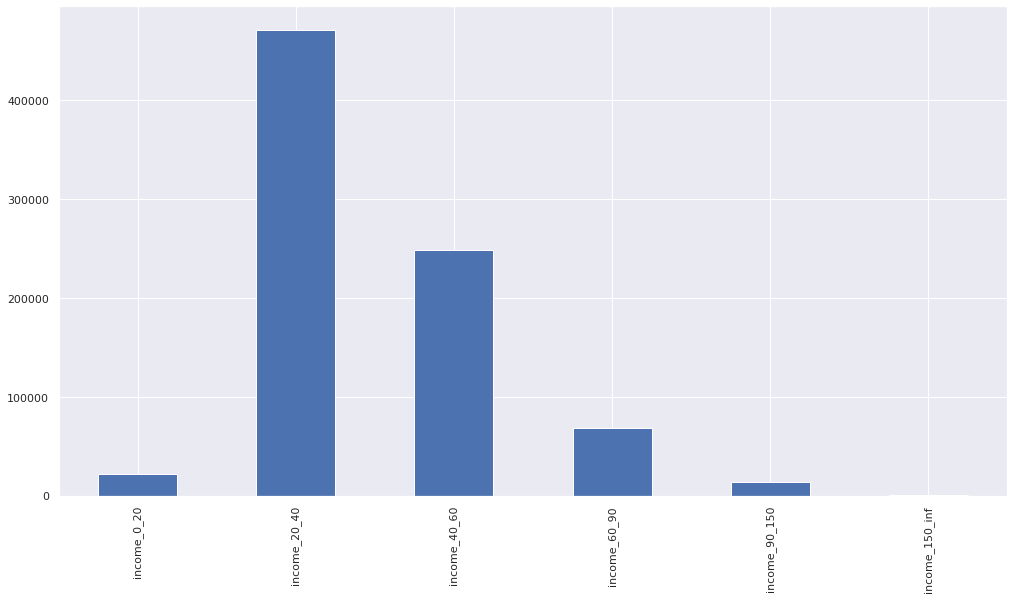

In [11]:
users_df.income.value_counts().iloc[[3,0,1,2,4,5]].plot(kind='bar')

In [12]:
users_df['income'] = users_df['income'].fillna('income_unknown')

In [13]:
users_df['income'].value_counts()

income_20_40      471519
income_40_60      248330
income_60_90       68674
income_0_20        21836
income_unknown     14776
income_90_150      13985
income_150_inf      1077
Name: income, dtype: int64

In [14]:
users_df['income'] = users_df['income'].astype('category')

#### Sex

In [15]:
users_df['sex'].value_counts()

Ж    425270
М    401096
Name: sex, dtype: int64

In [16]:
users_df['sex'] = users_df['sex'].fillna('sex_unknown')

In [17]:
users_df.loc[users_df.sex == 'М', 'sex'] = 'M'
users_df.loc[users_df.sex == 'Ж', 'sex'] = 'F'

In [18]:
users_df['sex'].value_counts()

F              425270
M              401096
sex_unknown     13831
Name: sex, dtype: int64

In [19]:
users_df['sex'] = users_df['sex'].astype('category')

#### kids_flg

In [20]:
users_df['kids_flg'].value_counts()

0    587209
1    252988
Name: kids_flg, dtype: int64

In [21]:
users_df['kids_flg'] = users_df['kids_flg'].astype('bool')

#### Duplicates check

In [22]:
users_df.duplicated(subset=['user_id'], keep=False).sum()

0

### Result

In [23]:
users_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840197 entries, 0 to 840196
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   user_id   840197 non-null  int64   
 1   age       840197 non-null  category
 2   income    840197 non-null  category
 3   sex       840197 non-null  category
 4   kids_flg  840197 non-null  bool    
dtypes: bool(1), category(3), int64(1)
memory usage: 9.6 MB


## Items

In [24]:
items_df.head(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."


In [25]:
items_df.nunique()

item_id         15963
content_type        2
title           15293
title_orig      10575
release_year      105
genres           2771
countries         687
for_kids            2
age_rating          6
studios            38
directors        7973
actors          12996
description     15619
keywords        15492
dtype: int64

In [26]:
items_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       15963 non-null  int64  
 1   content_type  15963 non-null  object 
 2   title         15963 non-null  object 
 3   title_orig    11218 non-null  object 
 4   release_year  15865 non-null  float64
 5   genres        15963 non-null  object 
 6   countries     15926 non-null  object 
 7   for_kids      566 non-null    float64
 8   age_rating    15961 non-null  float64
 9   studios       1065 non-null   object 
 10  directors     14454 non-null  object 
 11  actors        13344 non-null  object 
 12  description   15961 non-null  object 
 13  keywords      15540 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.7+ MB


### Preprocess

#### content_type

In [27]:
items_df.content_type.value_counts()

film      12002
series     3961
Name: content_type, dtype: int64

In [28]:
items_df['content_type'] = items_df['content_type'].astype('category')

#### title

In [29]:
items_df['title'].head()

0          Поговори с ней
1             Голые перцы
2        Тактическая сила
3                  45 лет
4    Все решает мгновение
Name: title, dtype: object

In [30]:
items_df.duplicated(subset=['title'], keep=False).sum()

1266

In [31]:
items_df['title'] = items_df['title'].str.lower()

#### title_orig

In [32]:
items_df['title_orig'].head()

0    Hable con ella
1      Search Party
2    Tactical Force
3          45 Years
4               NaN
Name: title_orig, dtype: object

In [33]:
items_df[items_df.title_orig.isna()].countries.value_counts().head()

Россия            2899
СССР               918
Украина            240
США                101
Великобритания      87
Name: countries, dtype: int64

In [34]:
items_df['title_orig'] = items_df['title_orig'].fillna('None') 

In [35]:
items_df.duplicated(subset=['title_orig'], keep=False).sum()

6007

In [36]:
items_df.duplicated(subset=['title', 'title_orig'], keep=False).sum()

380

#### release_year

<AxesSubplot:>

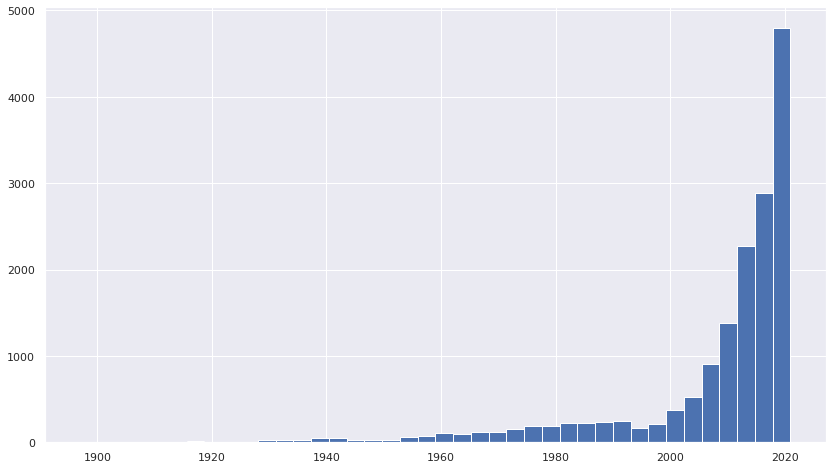

In [37]:
items_df.release_year.hist(figsize=(14, 8), bins=40)

In [38]:
items_df[items_df['release_year'].isna()].head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
89,10950,series,начни дома,None,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Приведи себя в хорошую форму дома с минимальны...,"Начни, дома, Россия, спорт-фитнес, спорт-трене..."
294,3901,series,красота лица,None,NaN,фитнес,Россия,NaN,0.0,NaN,NaN,NaN,"Motify научит вас простым, но очень эффективны...","Красота, лица, 2020, Россия, спорт-фитнес, спо..."
374,10656,series,медитации для жизни,None,NaN,фитнес,NaN,NaN,6.0,NaN,NaN,NaN,"В этой программе собраны 3 базовых урока, на к...","Медитации, для, жизни, спорт-фитнес, спорт-тре..."
375,11526,series,психология питания,None,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,В программе от Motify ты узнаешь о психологиче...,"Психология, питания"
572,11532,series,йога старт,None,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Программа от Motify подойдет для любого уровня...,"Йога, 2020, Россия, спорт-фитнес, спорт-тренер..."


In [39]:
items_df[items_df['release_year'].isna()][['age_rating', 'genres', 'countries']].value_counts()

age_rating  genres                                                 countries       
6.0         фитнес                                                 Россия              54
0.0         футбол                                                 Россия              22
            фитнес                                                 Россия               5
6.0         фитнес                                                 Великобритания       1
0.0         зарубежные, для детей, западные мультфильмы, развитие  Республика Корея     1
            зарубежные, детские песни, развитие, для детей         Республика Корея     1
dtype: int64

Год можно, например, преобразовать к категории следующим способом

In [40]:
items_df.loc[items_df['release_year'].isna(), 'release_year'] = 2020.

In [41]:
items_df.loc[items_df['release_year'] < 1920, 'release_year_cat'] = 'inf_1920'
items_df.loc[items_df['release_year'] >= 2020, 'release_year_cat'] = '2020_inf'

In [42]:
for i in range (1920, 2020, 10):
    items_df.loc[(items_df['release_year'] >= i) & (items_df['release_year'] < i+10), 'release_year_cat'] = f'{i}-{i+10}'

In [43]:
items_df.release_year_cat.value_counts()

2010-2020    8788
2020_inf     2276
2000-2010    2168
1980-1990     745
1990-2000     636
1970-1980     553
1960-1970     342
1950-1960     199
1940-1950     117
1930-1940     104
1920-1930      24
inf_1920       11
Name: release_year_cat, dtype: int64

In [44]:
items_df = items_df.drop(columns=['release_year'])
items_df['release_year_cat'] = items_df['release_year_cat'].astype('category')

#### genres

In [45]:
items_df.genres.value_counts()

документальное                                     816
драмы                                              719
комедии                                            564
для взрослых                                       482
русские, мелодрамы                                 416
                                                  ... 
историческое, комедии, криминал, документальное      1
ужасы, мультфильм, фэнтези, комедии                  1
зарубежные, мистика, приключения, ужасы              1
фэнтези, короткометражные                            1
фантастика, мультсериалы                             1
Name: genres, Length: 2771, dtype: int64

In [46]:
items_df['genres'] = items_df['genres'].astype('category')

#### countries

In [47]:
items_df.countries.value_counts()

Россия                                              4237
США                                                 4090
СССР                                                1401
Франция                                             1158
Великобритания                                       718
                                                    ... 
Финляндия, Германия                                    1
Франция, Япония                                        1
США, Германия, Мексика                                 1
Россия, Великобритания, Австрия                        1
Россия, Украина, Германия, Великобритания, Чехия       1
Name: countries, Length: 687, dtype: int64

In [48]:
items_df[items_df.countries.isna()].shape

(37, 14)

In [49]:
items_df[items_df.countries.isna()].head()

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
374,10656,series,медитации для жизни,None,фитнес,NaN,NaN,6.0,NaN,NaN,NaN,"В этой программе собраны 3 базовых урока, на к...","Медитации, для, жизни, спорт-фитнес, спорт-тре...",2020_inf
375,11526,series,психология питания,None,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,В программе от Motify ты узнаешь о психологиче...,"Психология, питания",2020_inf
573,63,series,пробуди силу духа,None,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Три коротких и энергичных класса Кундалини йог...,"Пробуди, силу, Духа, 2021, спорт-фитнес, спорт...",2020_inf
750,11551,series,растяжка для кaждого,None,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Программа от Motify поможет вам почувствовать ...,"Растяжка, для, кaждого",2020_inf
1960,16014,series,работа с телом для молодости лица,None,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Программа от Motify направлена на работу с тел...,"Работа, телом, для, молодости, лица",2020_inf


In [50]:
items_df.loc[items_df.countries.isna(), 'countries'] = 'Россия'

In [51]:
items_df['countries'] = items_df['countries'].str.lower()
items_df['countries'] = items_df['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [52]:
items_df.countries.value_counts().head(10)

россия                 4274
сша                    4090
ссср                   1401
франция                1158
великобритания          718
украина                 340
италия                  256
канада                  233
республика корея        230
великобритания, сша     193
Name: countries, dtype: int64

In [53]:
items_df['countries'] = items_df['countries'].astype('category')

#### for_kids

In [54]:
items_df['for_kids'].value_counts()

0.0    452
1.0    114
Name: for_kids, dtype: int64

In [55]:
items_df['for_kids'] = items_df['for_kids'].fillna(0)

In [56]:
items_df['for_kids'] = items_df['for_kids'].astype('bool')

#### age_rating

In [57]:
items_df.age_rating.value_counts()

16.0    5729
12.0    4147
18.0    2547
6.0     1538
0.0     1518
21.0     482
Name: age_rating, dtype: int64

In [58]:
items_df[items_df.age_rating.isna()]

,item_id,content_type,title,title_orig,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,release_year_cat
8297,6316,series,машины-помощники,None,"русские, для детей, сериалы, хочу всё знать, р...",россия,False,NaN,NaN,NaN,NaN,Маленькие мальчики всего мира любят играть в м...,"Машины-помощники, 2017, Россия, работа, преодо...",2010-2020
12352,14409,series,бибабу,None,"русские, сериалы, для детей, хочу всё знать, р...",россия,False,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан...",2010-2020


In [59]:
items_df.loc[items_df.age_rating.isna(), 'age_rating'] = 0

In [60]:
items_df['age_rating'] = items_df['age_rating'].astype('category')

#### studios

In [61]:
items_df['studios'] = items_df['studios'].fillna('Unknown')

In [62]:
items_df['studios'] = items_df['studios'].str.lower()
items_df['studios'] = items_df['studios'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))

In [63]:
items_df['studios'] = items_df['studios'].astype('category')

#### directors

In [64]:
items_df['directors'] = items_df['directors'].fillna('Unknown')

In [65]:
items_df['directors'] = items_df['directors'].str.lower()

In [66]:
items_df['directors'] = items_df['directors'].astype('category')

#### actors

In [67]:
items_df['actors'] = items_df['actors'].fillna('Unknown')

In [68]:
items_df['actors'] = items_df['actors'].astype('category')

#### keywords

In [69]:
items_df['keywords'].head()

0    Поговори, ней, 2002, Испания, друзья, любовь, ...
1    Голые, перцы, 2014, США, друзья, свадьбы, прео...
2    Тактическая, сила, 2011, Канада, бандиты, ганг...
3    45, лет, 2015, Великобритания, брак, жизнь, лю...
4    Все, решает, мгновение, 1978, СССР, сильные, ж...
Name: keywords, dtype: object

In [70]:
items_df['keywords'] = items_df['keywords'].fillna('Unknown')

Другой вариант - можно заполнить пропуски копипастой из других фич

In [71]:
items_df['keywords'] = items_df['keywords'].astype('category')

#### description

In [72]:
items_df['description'] = items_df['description'].fillna('-')

#### Duplicates check

In [73]:
items_df.duplicated(subset=['item_id'], keep=False).sum()

0

In [74]:
items_df.duplicated(subset=['title'], keep=False).sum()

1300

In [75]:
items_df[items_df.duplicated(subset=['content_type', 'countries', 'title', 'directors'], keep=False)].sort_values('title')[['content_type', 'title', 'countries', 'for_kids', 'directors']].head()

,content_type,title,countries,for_kids,directors
7333,film,пираты по соседству,нидерланды,False,пим ван хёве
12757,film,пираты по соседству,нидерланды,False,пим ван хёве


In [76]:
items_df.duplicated(subset=['content_type', 'countries', 'title', 'directors'], keep=False).sum()

2

### Result

In [77]:
items_df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15963 entries, 0 to 15962
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   item_id           15963 non-null  int64   
 1   content_type      15963 non-null  category
 2   title             15963 non-null  object  
 3   title_orig        15963 non-null  object  
 4   genres            15963 non-null  category
 5   countries         15963 non-null  category
 6   for_kids          15963 non-null  bool    
 7   age_rating        15963 non-null  category
 8   studios           15963 non-null  category
 9   directors         15963 non-null  category
 10  actors            15963 non-null  category
 11  description       15963 non-null  object  
 12  keywords          15963 non-null  category
 13  release_year_cat  15963 non-null  category
dtypes: bool(1), category(9), int64(1), object(3)
memory usage: 2.7+ MB


## Interactions

In [78]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [79]:
interactions_df.shape

(5476251, 5)

In [80]:
interactions_df.nunique()

user_id          962179
item_id           15706
last_watch_dt       163
total_dur        129788
watched_pct         101
dtype: int64

In [81]:
print(f'Data date range: {interactions_df.last_watch_dt.min().date()} - {interactions_df.last_watch_dt.max().date()}')

Data date range: 2021-03-13 - 2021-08-22


In [82]:
interactions_df.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        5476251 non-null  int64         
 1   item_id        5476251 non-null  int64         
 2   last_watch_dt  5476251 non-null  datetime64[ns]
 3   total_dur      5476251 non-null  int64         
 4   watched_pct    5475423 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


### Preprocessing

#### watched_pct

In [83]:
interactions_df.watched_pct.max()

100.0

In [84]:
interactions_df.watched_pct.min()

0.0

In [85]:
interactions_df['watched_pct'] = interactions_df['watched_pct'].astype(pd.Int8Dtype())

In [86]:
interactions_df['watched_pct'] = interactions_df['watched_pct'].fillna(0)

<AxesSubplot:>

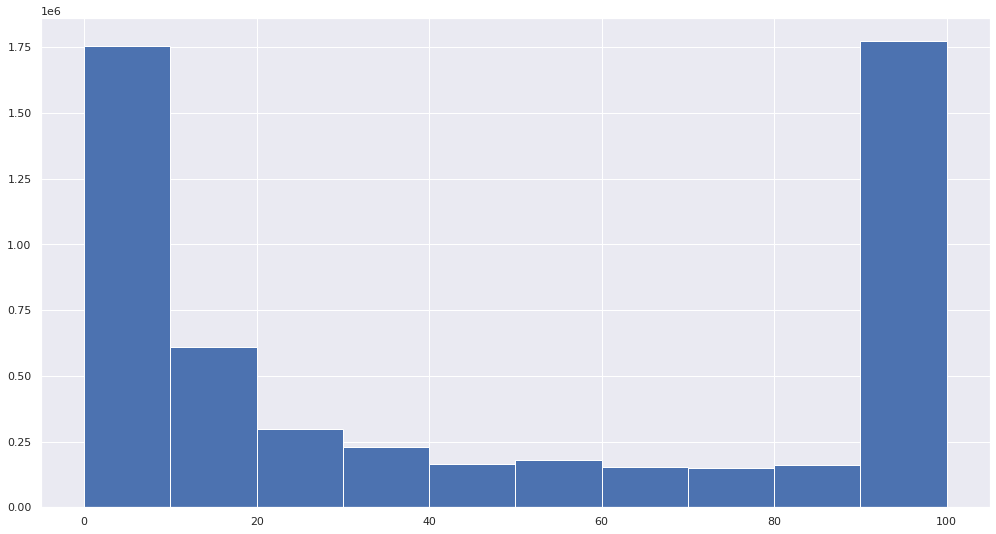

In [87]:
interactions_df['watched_pct'].hist()

#### total_dur

<AxesSubplot:>

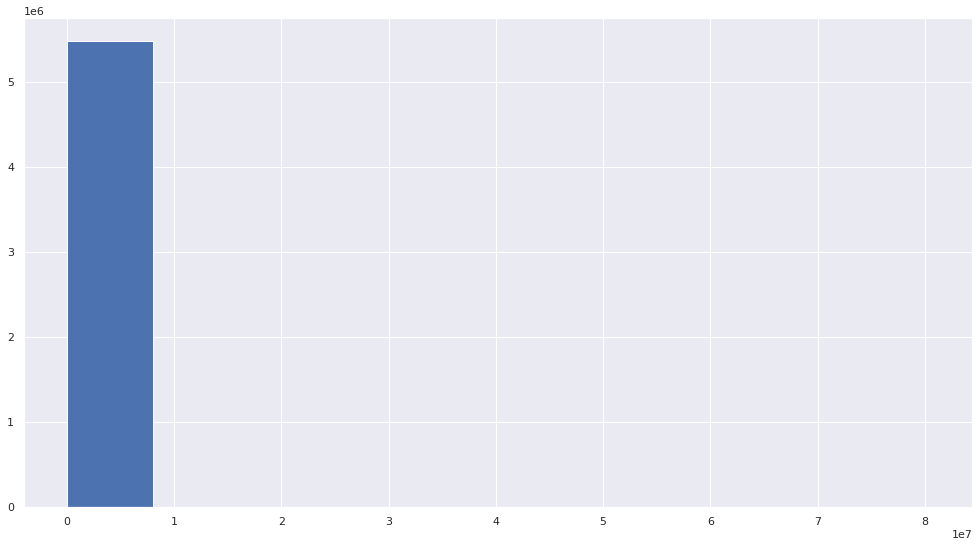

In [88]:
interactions_df['total_dur'].hist()

In [89]:
interactions_df[interactions_df['total_dur'] > 200000].shape

(16042, 5)

<AxesSubplot:>

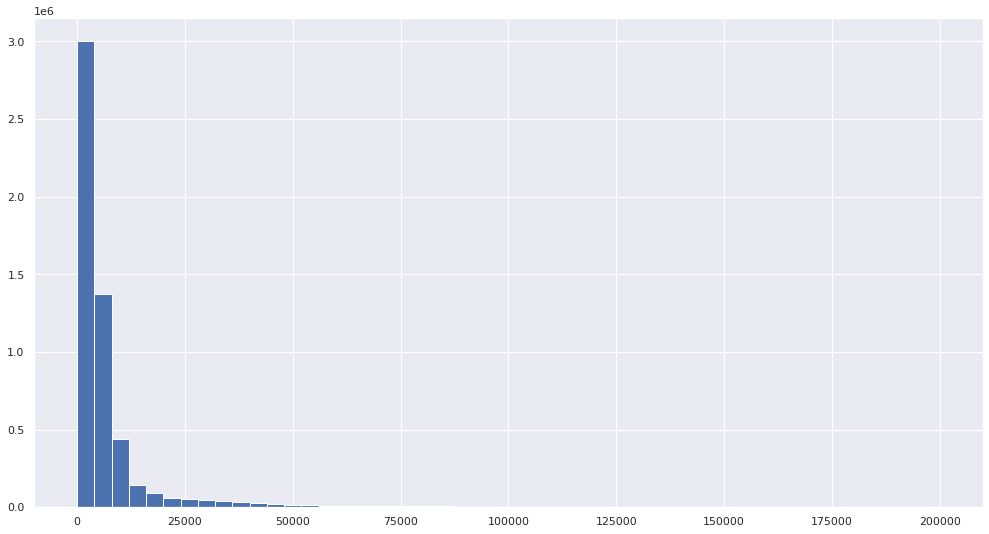

In [90]:
interactions_df[interactions_df['total_dur'] < 200000].total_dur.hist(bins=50)

#### last_watch_dt

In [91]:
interactions_df['last_watch_dt'] = pd.to_datetime(interactions_df['last_watch_dt'])

In [92]:
interactions_df['last_watch_dt'].min()

Timestamp('2021-03-13 00:00:00')

In [93]:
interactions_df['last_watch_dt'].max()

Timestamp('2021-08-22 00:00:00')

<AxesSubplot:>

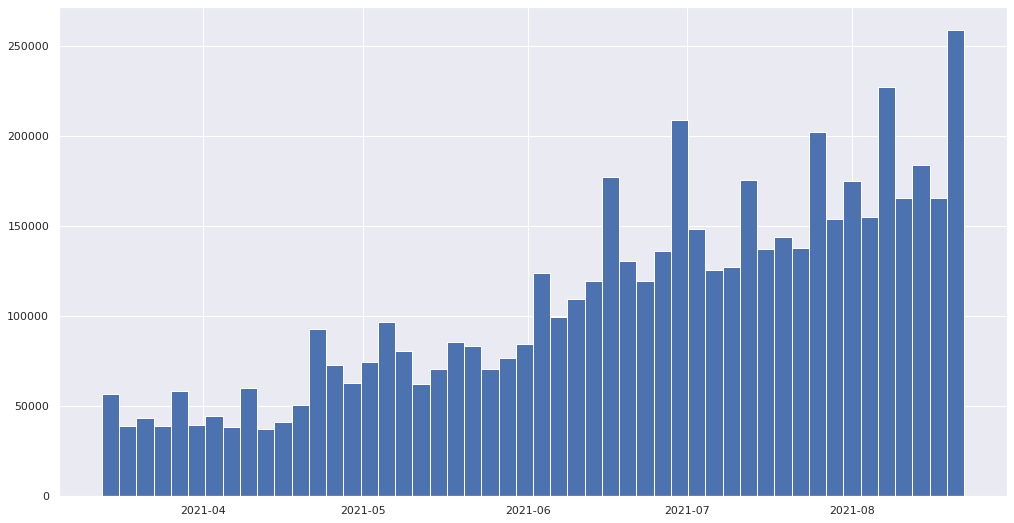

In [94]:
interactions_df['last_watch_dt'].hist(bins=50)

#### Duplicates check

In [95]:
interactions_df.duplicated(subset=['user_id', 'item_id'], keep=False).sum()

0

### Result

In [96]:
interactions_df.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   user_id        5476251 non-null  int64         
 1   item_id        5476251 non-null  int64         
 2   last_watch_dt  5476251 non-null  datetime64[ns]
 3   total_dur      5476251 non-null  int64         
 4   watched_pct    5476251 non-null  Int8          
dtypes: Int8(1), datetime64[ns](1), int64(3)
memory usage: 177.6 MB


# Some stats

In [97]:
interaction_users = interactions_df['user_id'].unique()

common_users = len(np.intersect1d(interaction_users, users_df['user_id']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, users_df['user_id']))
users_only_features = len(np.setdiff1d(users_df['user_id'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features

print(f'Кол-во пользователей всего - {total_users}')
print(f'Кол-во пользователей c взаимодействиями и фичами - {common_users} ({common_users / total_users:.2%})')
print(f'Кол-во пользователей только c взаимодействиями - {users_only_in_interaction} ({users_only_in_interaction / total_users:.2%})')
print(f'Кол-во пользователей только c фичами - {users_only_features} ({users_only_features / total_users:.2%})')

Кол-во пользователей всего - 1058088
Кол-во пользователей c взаимодействиями и фичами - 744288 (70.34%)
Кол-во пользователей только c взаимодействиями - 217891 (20.59%)
Кол-во пользователей только c фичами - 95909 (9.06%)


In [98]:
interaction_items = interactions_df['item_id'].unique()

common_items = len(np.intersect1d(interaction_items, items_df['item_id']))
items_only_in_interaction = len(np.setdiff1d(interaction_items, items_df['item_id']))
items_only_features = len(np.setdiff1d(items_df['item_id'], interaction_items))
total_items = common_items + items_only_in_interaction + items_only_features
print(f'Кол-во объектов всего - {total_items}')
print(f'Кол-во объектов c взаимодействиями и фичами - {common_items} ({common_items / total_items:.2%})')
print(f'Кол-во объектов только c взаимодействиями - {items_only_in_interaction} ({items_only_in_interaction / total_items:.2%})')
print(f'Кол-во объектов только c фичами - {items_only_features} ({items_only_features / total_items:.2%})')

Кол-во объектов всего - 15963
Кол-во объектов c взаимодействиями и фичами - 15706 (98.39%)
Кол-во объектов только c взаимодействиями - 0 (0.00%)
Кол-во объектов только c фичами - 257 (1.61%)


График количества пользователей от даты

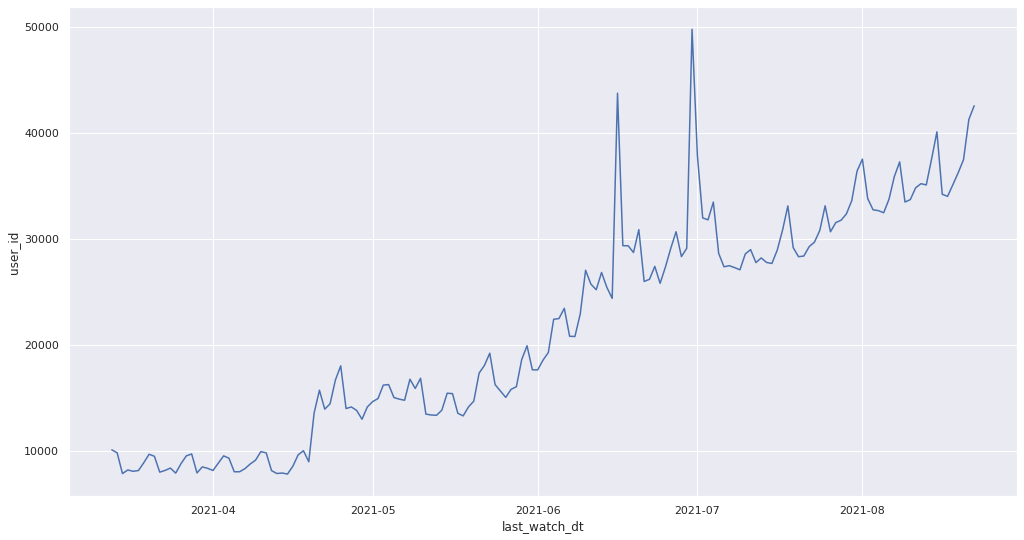

In [99]:
interactions_df_users_count = interactions_df.groupby('last_watch_dt').agg({'user_id': pd.Series.nunique}).reset_index().sort_values('last_watch_dt')
sns.lineplot(data=interactions_df_users_count, x='last_watch_dt', y='user_id');

График количества уникальных пользователей от даты

In [100]:
interactions_df_unique_users_count = []
unique_users = set()

for date in sorted(interactions_df.last_watch_dt.unique()):
    date_unique_users = interactions_df[interactions_df.last_watch_dt == date].user_id.unique()
    interactions_df_unique_users_count.append((date, len(set(date_unique_users) - unique_users)))
    unique_users = unique_users.union(set(date_unique_users))

<AxesSubplot:xlabel='date', ylabel='count'>

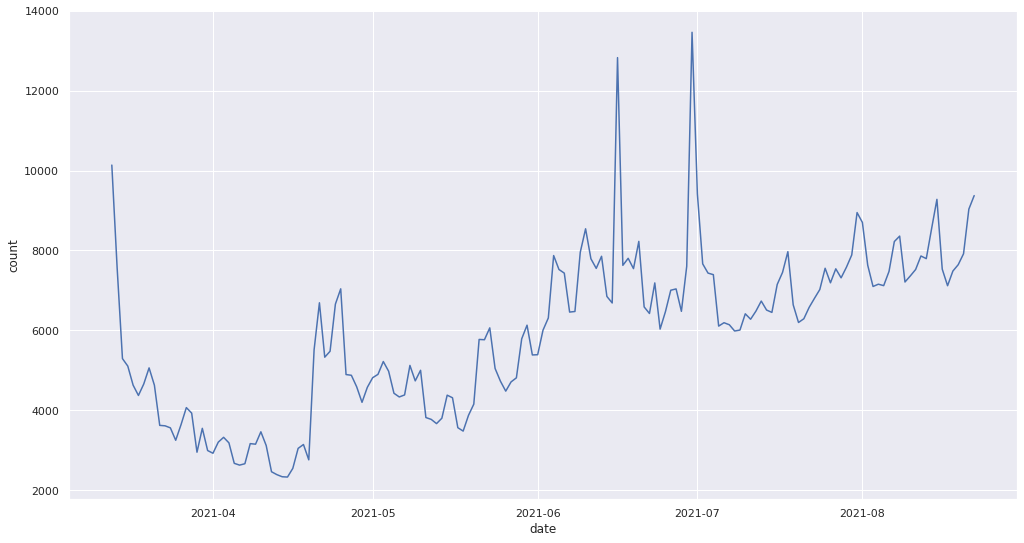

In [101]:
sns.lineplot(data=pd.DataFrame(interactions_df_unique_users_count, columns=['date', 'count']), x='date', y='count') 

Ага, очевидно, что каждый день есть у нас есть холодные пользователи. Это необходимо учесть в модели и по хорошему - придумать, что с ними делать

Посмотрим на обьекты

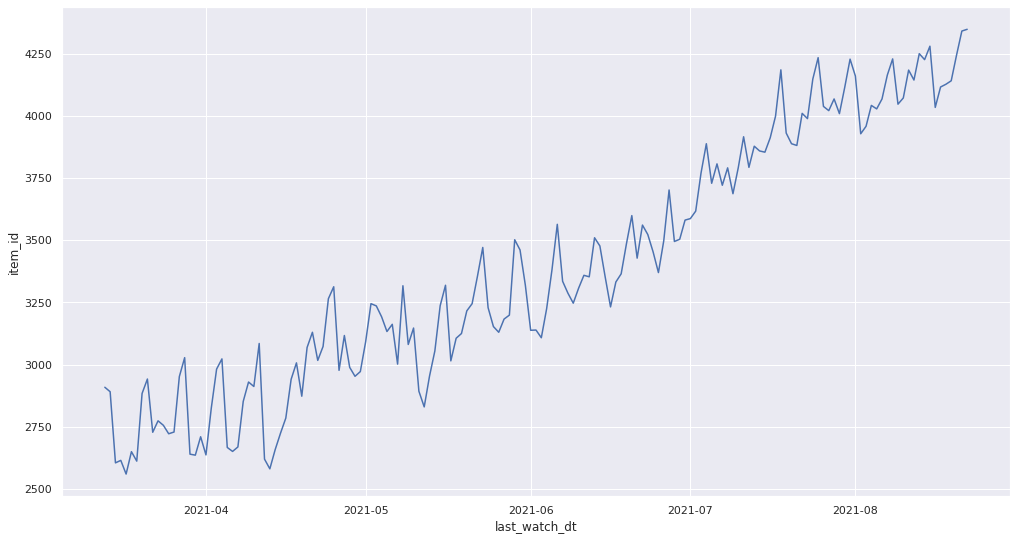

In [102]:
interactions_df_items_count = interactions_df.groupby('last_watch_dt').agg({'item_id': pd.Series.nunique}).reset_index().sort_values('last_watch_dt')
sns.lineplot(data=interactions_df_items_count, x='last_watch_dt', y='item_id');

In [103]:
interactions_df_unique_items_count = []
unique_items = set()

for date in sorted(interactions_df.last_watch_dt.unique()):
    date_unique_items = interactions_df[interactions_df.last_watch_dt == date].item_id.unique()
    interactions_df_unique_items_count.append((date, len(set(date_unique_items) - unique_items)))
    unique_items = unique_items.union(set(date_unique_items))
    
interactions_df_unique_items_count = pd.DataFrame(interactions_df_unique_items_count, columns=['date', 'count'])

<AxesSubplot:xlabel='date', ylabel='count'>

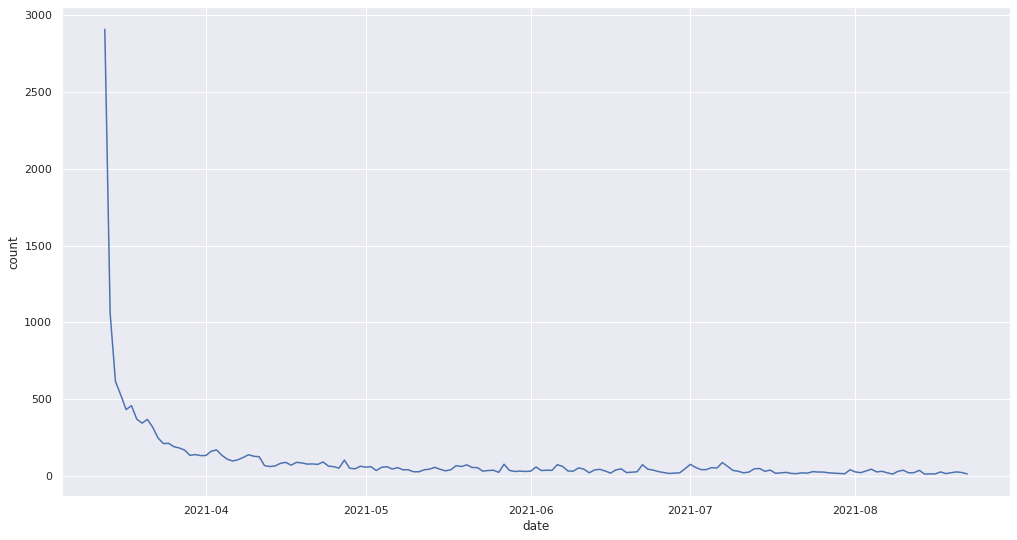

In [104]:
sns.lineplot(data=interactions_df_unique_items_count, x='date', y='count') 

<AxesSubplot:xlabel='date', ylabel='count'>

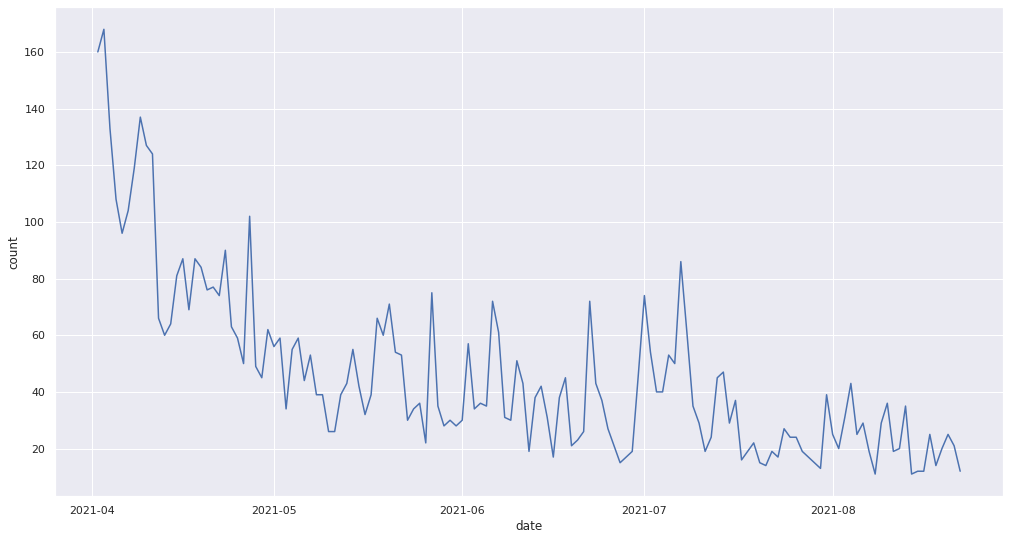

In [105]:
sns.lineplot(data=interactions_df_unique_items_count[interactions_df_unique_items_count.date > '2021-04-01'], x='date', y='count') 

Холодные объекты тоже есть, но их явно меньше

Посмотрим на юзеров, для которых нам предсказывать

In [106]:
submission.head()

,user_id,item_id
0,3,"[13865, 15297, 9996, 7310, 2954, 7417, 7829, 9..."
1,11,"[10440, 13865, 4151, 9728, 142, 3734, 9996, 26..."
2,30,"[13865, 10440, 6444, 15297, 3734, 10525, 12995..."
3,39,"[4151, 10440, 12192, 3734, 13865, 142, 16228, ..."
4,46,"[15297, 13865, 9728, 9996, 12192, 3734, 2657, ..."


In [107]:
interactions_df.user_id.nunique()

962179

In [108]:
submission.user_id.nunique()

193113

In [109]:
len(set(submission.user_id.unique())-set(interactions_df.user_id.unique()))

64943

64943 пользователей из 193113 у нас холодные

Посмотрим сколько взаимодействий по теплым

In [110]:
interactions_of_sub_users = interactions_df[interactions_df.user_id.isin(submission.user_id.unique())]

In [111]:
interactions_of_sub_users.groupby('user_id').agg({'item_id': 'count'}).reset_index().item_id.value_counts().head(10)

1     17001
2     12777
3     10473
4      8854
5      7436
6      6471
7      5745
8      4995
9      4426
10     3890
Name: item_id, dtype: int64

# Сохранение

In [112]:
users_df.to_csv('users_processed.csv', index=False)
items_df.to_csv('items_processed.csv', index=False)
interactions_df.to_csv('interactions_processed.csv', index=False)